# Latent Population Analysis with Calcium likelihoods

The following notebook will simulate neural population activity with LDS structure, and run GPFA and LDS inference on it with the the Ganmor Calcium likelihood.

Make sure you have the following packages in your environment:<br />
autograd <br />
jax<br />
cython<br />
ipywidgets<br />
pandas<br />
ssm


There is an environment file in the github repo that should be work to install all relevant packages.

In [1]:
import autograd.numpy as anp
import autograd.numpy.random as npr

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns


import jax
import jax.numpy as jnp
# Current convention is to import original numpy as "onp"
import numpy as onp
from jax import grad, jit, vmap
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of 
from jax import random
from jax import jacfwd
from functools import partial

import GP_fourier as gpf 
from CA.CA_new import CA_Emissions
from CA.misc import bbvi, make_cov, softplus



In [2]:
npr.seed(123)
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]
colors = sns.xkcd_palette(color_names)

from ssm import LDS
from ssm.util import random_rotation


### Simulate (AR1) LDS data

In [60]:
T = 1000   # number of time bins
D = 2      # number of latent dimensions
N = 40     # number of observed dimensions
bin_size = 0.01
link_func = "softplus"
# Make an LDS with somewhat interesting dynamics parameters
true_lds = LDS(N, D, emissions="calcium", emission_kwargs={"bin_size":bin_size,"link":link_func})
A0 = .99 * random_rotation(D, theta=anp.pi/40)
# S = (1 + 3 * npr.rand(D))
S = anp.arange(1, D+1)
R = anp.linalg.svd(npr.randn(D, D))[0] * S
A = R.dot(A0).dot(anp.linalg.inv(R))
b =  anp.zeros(D)
true_lds.dynamics.As[0] = A
true_lds.dynamics.bs[0] = b
true_lds.dynamics.Sigmas = true_lds.dynamics.Sigmas / anp.max(true_lds.dynamics.Sigmas[0]) * 0.5
# true_lds.dynamics.Sigmas = true_lds.dynamics.Sigmas 
# true_lds.emissions.ds[0] = np.clip(npr.randn(N), -10, 0.1)
true_lds.emissions.ds[0] = 10.0 + 3.0 * npr.randn(N)
true_lds.emissions.As[0] = anp.clip(0.85 + 0.05 * npr.randn(N), 0.8, 0.95)
true_lds.emissions.betas[0] = 1.0 * anp.ones(N)



# set noise on correct scale
true_lds.emissions.inv_etas[0] = anp.log(1e-2 * anp.ones(N))

x, y = true_lds.sample(T)
smooth_y = true_lds.smooth(x, y)

u = onp.zeros((T,0))
mask = onp.ones_like(y)
tag = None
lls = true_lds.emissions.log_likelihoods(y, u, mask, tag, x)

lambdas = true_lds.emissions.mean(true_lds.emissions.forward(x, u, tag))[:,0,:]


# plt.ion()
# plt.figure()
# plt.plot(x)

### LDS inference

In [ ]:

test_As = anp.zeros_like(true_lds.emissions.As[0])
test_As = true_lds.emissions.As[0] + 0.0
test_etas = anp.zeros_like(true_lds.emissions.inv_etas[0])
for d in range(N):
    yd = y[:,d]
    # test_As[d] = 1.0 / np.sum(yd[:-1] **2 ) * np.dot(yd[:-1], yd[1:]) * 1.0 # deflate because not taking into account spikes
    sqerr = anp.sum( ( yd[1:] - test_As[d] * yd[:-1] )**2 ) / (T-1)
    test_etas[d] = sqerr 
    
    lds = LDS(N, D, emissions="calcium", emission_kwargs={"bin_size":bin_size,"link":"softplus"})
# lds.emissions.As[0] = true_lds.emissions.As[0]
# lds.emissions.betas[0] = true_lds.emissions.betas[0]
# lds.emissions.inv_etas[0] = true_lds.emissions.inv_etas[0]
lds.emissions.As[0] = test_As
# lds.emissions.betas[0] = true_lds.emissions.betas[0]
lds.emissions.inv_etas[0] = anp.log(test_etas)
lds.initialize(y)
lds.emissions.ds = true_lds.emissions.ds + 3.0 * npr.randn(N)
q_elbos, q = lds.fit(y, method="laplace_em", variational_posterior="structured_meanfield", 
                            num_iters=25, initialize=False,
                            continuous_optimizer="lbfgs")

# fit gaussian
lds_gauss = LDS(N, D, emissions="gaussian")
lds_gauss.initialize(y)
q_elbos_gauss, q_gauss = lds_gauss.fit(y, method="laplace_em", variational_posterior="structured_meanfield", 
                            num_iters=25, initialize=False,
                            continuous_optimizer="newton")

# q_mf_x = q_mf.mean[0]
q_x = q.mean_continuous_states[0]
from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=False)
lr.fit(q_x, x)
q_x_trans = lr.predict(q_x)

q_x_gauss = q_gauss.mean_continuous_states[0]
from sklearn.linear_model import LinearRegression
lr_gauss = LinearRegression(fit_intercept=False)
lr_gauss.fit(q_x_gauss, x)
q_x_trans_gauss = lr.predict(q_x_gauss)


### GPFA

Start by defining some specific functions needed for the current GPFA

In [38]:
def calc_gp_prior(X, K,n_lats, Fourier = False):
	'''
	Calculates the GP log prior (time domain)
	x_samples should be nsamples by T
	K is T by T
	'''
	total_prior = 0
	if Fourier:
		for i in jnp.arange(n_lats):
			x_lat = X[i]
			total_prior = total_prior -(1/2)*(jnp.sum(jnp.square(x_lat)/K[i])+ jnp.sum(jnp.log(2*jnp.pi*K[i])))  

	else:
        ### not yet finished below, not working for >1 latent dimensions!
		Kinv = jnp.linalg.inv(K)
		log_prior = -(1/2)*(onp.shape(Kinv)[0]*np.log(2*np.pi) + jnp.matmul(rate,np.matmul(Kinv,rate))+ jnp.linalg.slogdet(K)[1]) 

	return total_prior


def log_joint(Y, X,  model_params, ca_obj,  n_lats, nlags, Fourier = False, nxcirc = None, wwnrm = None, Bf = None, learn_model_params  = False, learn_per_neuron = False, Gauss = False):

    # logjoint here can work in fourier domain or not.
    # If Fourier, need to pass in Fourier args (nxcirc, wwnrm, bf)

    # logjoint can also learn calcium hyperparams (tau, alpha, marginal variance) or not
    # if yes, please append these to they hyperparams argument AFTER the rho and length scale

    # X should be passed in as samples by neurons by latents
    #model params is a single vector of loadings then length scales than CA params
    X = jnp.reshape(X, [n_lats, -1])
    n_neurons = jnp.shape(Y)[0]
    loadings_hat = jnp.reshape(model_params[0:n_neurons*n_lats], [n_neurons,n_lats])
    ls_hat = model_params[n_neurons*n_lats:n_neurons*n_lats+n_lats]


    if Fourier:
        K = gpf.mkcovs.mkcovdiag_ASD_wellcond(ls_hat, jnp.ones(jnp.size(ls_hat)), nxcirc, wwnrm = wwnrm,addition = 1e-7).T
        if n_lats == 1:
            K = jnp.expand_dims(K, axis = 0)
        log_prior = calc_gp_prior(X, K, n_lats, Fourier = True)


        params = jnp.matmul(X, Bf)
        rates = loadings_hat@params


        if learn_model_params:
            if learn_per_neuron:
                param_butt = jnp.reshape(model_params[n_neurons*n_lats+n_lats:], [n_neurons,-1])
            else:
                param_butt = jnp.tile(model_params[n_neurons*n_lats+n_lats:], [n_neurons,1])	


            rates =jnp.append(rates, jnp.array(param_butt), axis = 1)


    else:
        K = make_cov(ca_obj.Tps, model_params[0], model_params[1]) + jnp.eye(ca_obj.Tps)*1e-2 #need heavy regularization here. (might be differnet for different opt params)
        log_prior = calc_gp_prior(X, K)
        if learn_model_params :
            params = jnp.append(X, model_params[2:])

    if Gauss:

        ll = ca_obj.gauss_log_likelihood(Y, rates, nlags, learn_model_params  = learn_model_params)
        
    else:    
        ll = ca_obj.log_likelihood(Y, rates, nlags,  learn_model_params  = learn_model_params)

    return log_prior + ll

In [ ]:

a = onp.random.randn(n_neurons,n_lats+1)
a[:,-1]

And run GPFA inference

In [61]:
timepoints = T
lscs = [150,150]
n_lats = 2
n_neurons = N

As = onp.mean(true_lds.emissions.As[0]) ### for now set to average of true As from David's code
AR = onp.size(As) ### AR 1 for now
logGauss_sigma = onp.mean(true_lds.emissions.inv_etas[0])### for now set to average of true log noise from David's code

ca_obj = CA_Emissions(AR = AR, As = jnp.array([[A]]).T, Gauss_sigma = jnp.array(jnp.exp(logGauss_sigma)), alpha = jnp.array([1]),link = "softplus",Tps = timepoints, dt = bin_size) #generate AR1 calcium object


####### Fourier Domain #############
minlens = 30 #assert a minimum scale for eigenvalue thresholding
nxc_ext = 0.03



##### in the LDS the data is y, here it is samp_data, so plugging in the same data.
samp_data = y.T



_, wwnrm, Bffts, nxcirc = gpf.comp_fourier.conv_fourier([samp_data[0]], ca_obj.Tps, minlens,nxcirc = jnp.array([ca_obj.Tps+nxc_ext*ca_obj.Tps]))
N_four = Bffts[0].shape[0]


num_samples = 15

rate_length = N_four
var_mean = jnp.zeros(rate_length*n_lats, jnp.float64)
log_var_scale = -5* jnp.ones(rate_length*n_lats, jnp.float64)


init_ls = jnp.array([50,50], jnp.float64)
init_loadings = jnp.zeros(n_lats*n_neurons, jnp.float64)/n_neurons

loginit_marg_var = jnp.array([logGauss_sigma], jnp.float64)  ##init at true value
init_alpha = jnp.array([1], jnp.float64)
#init_As = jnp.array([1.81,-.82], jnp.float64)
init_As = jnp.array([As])## init at true value
AR = 1
nlags = AR

ca_obj = CA_Emissions(AR = AR, As = jnp.array([init_As]).T, Gauss_sigma = jnp.exp(loginit_marg_var), alpha = init_alpha ,link = "softplus",Tps = timepoints, dt = bin_size) #generate AR1 calcium object


full_params = jnp.concatenate([var_mean, log_var_scale, init_loadings,init_ls,jnp.exp(loginit_marg_var), init_alpha,   init_As])

log_joint_handle = lambda samp_data, samples, hyperparams, ca_obj, n_lats, nlags: log_joint(samp_data, samples, hyperparams, ca_obj, n_lats, nlags, Fourier = True, 
                                                                                            learn_model_params  =True, Bf=Bffts[0], wwnrm = wwnrm, nxcirc = nxcirc, Gauss = True)

#log_joint_handle = jit(log_joint_handle, static_argnums=(3,4,5,))


log_joint_fullparams = lambda samples, hyperparams: log_joint_handle(samp_data, samples, hyperparams, ca_obj, n_lats, nlags)

varobjective, unpack_params = bbvi(log_joint_fullparams, rate_length*n_lats, num_samples) #first argument (log_joint_fullparams) has to be a function of two arguments in BBVI (else we change BBVI)






###### ADAM #############

opt_init, opt_update, opt_get_params = optimizers.adam(step_size=.05)
opt_state = opt_init(full_params)

key = random.PRNGKey(10003)
# Define a compiled update step
#@jax.partial(jit, static_argnums = 3)
@jit
def step(i, key, opt_state):

	objective = lambda full_params: varobjective(full_params, key)  ### pass new key to objective for sampling
	full_params = opt_get_params(opt_state)
	g = grad(objective)(full_params)
	return opt_update(i, g, opt_state)



elbos = []
maxiter = 8600
for i in range(maxiter):
	key, subkey = random.split(key)
	opt_state = step(i, key, opt_state)
	if i % 100 == 0:
		elbo_val = varobjective(opt_get_params(opt_state), key)
		print("iteration:",i,"of", maxiter, "ELBO:", elbo_val)
		elbos.append(elbo_val)
print("Optimization done!")
final_params = opt_get_params(opt_state)


lat_mean, var, model_params = unpack_params(final_params)
loadings_hat = jnp.reshape(model_params[0:n_neurons*n_lats], [n_neurons,n_lats])
ls_hat = model_params[n_neurons*n_lats:n_neurons*n_lats+n_lats]




lat_mean = jnp.reshape(lat_mean[:N_four*n_lats], [n_lats, N_four])
recon_latent = lat_mean@Bffts[0]











/Users/skeeley/anaconda3/envs/ca_like/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2872: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "zeros")
/Users/skeeley/anaconda3/envs/ca_like/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:2881: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in ones is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "ones")
/Users/skeeley/anaconda3/env

iteration: 0 of 8600 ELBO: 390201.1
iteration: 100 of 8600 ELBO: 44087.754
iteration: 200 of 8600 ELBO: 40044.53
iteration: 300 of 8600 ELBO: 39948.418
iteration: 400 of 8600 ELBO: 39891.535
iteration: 500 of 8600 ELBO: 39830.57
iteration: 600 of 8600 ELBO: 39788.355
iteration: 700 of 8600 ELBO: 39743.867
iteration: 800 of 8600 ELBO: 39700.54
iteration: 900 of 8600 ELBO: 39673.383
iteration: 1000 of 8600 ELBO: 39649.652
iteration: 1100 of 8600 ELBO: 39618.895
iteration: 1200 of 8600 ELBO: 39604.76
iteration: 1300 of 8600 ELBO: 39588.812
iteration: 1400 of 8600 ELBO: 39573.35
iteration: 1500 of 8600 ELBO: 39558.33
iteration: 1600 of 8600 ELBO: 39563.668
iteration: 1700 of 8600 ELBO: 39553.27
iteration: 1800 of 8600 ELBO: 39541.37
iteration: 1900 of 8600 ELBO: 39541.68
iteration: 2000 of 8600 ELBO: 39533.29
iteration: 2100 of 8600 ELBO: 39532.8
iteration: 2200 of 8600 ELBO: 39531.555
iteration: 2300 of 8600 ELBO: 39517.64
iteration: 2400 of 8600 ELBO: 39520.027
iteration: 2500 of 8600 EL

Generate Plots

LDS

In [ ]:
ls_hat

In [ ]:
### LDS
plt.figure()
plt.plot(q_elbos[1:], color=colors[0], label="calcium")
plt.plot(q_elbos_gauss[1:], color=colors[1], label="gauss")
plt.legend()

plt.figure(figsize=(8,4))
# plt.subplot(211)
# plt.plot(x + 4 * np.arange(D), '-k')
for d in range(D):
    plt.plot(x[:,d] + 4 * d, '-k', label="true" if d==0 else None)
    plt.plot(q_x_trans[:,d] + 4 * d, '-', color=colors[0], label="calcium" if d==0 else None)
    plt.plot(q_x_trans_gauss[:,d] + 4 * d, '-', color=colors[1], label="gauss" if d==0 else None)
plt.ylabel("$x$")
plt.xlim((0,1000))
plt.legend()

smooth_y = lds.smooth(q_x, y)
smooth_y_gauss = lds_gauss.smooth(q_x_gauss, y)

# plt.subplot(212)
plt.figure()
for n in range(N): 
    plt.plot(y[:, n] + 4 * n, '-k', label="true" if d==0 else None)
    plt.plot(smooth_y[:, n] + 4 * n, '--', color=colors[0], label="MF" if d==0 else None)
    plt.plot(smooth_y_gauss[:, n] + 4 * n, '--', color=colors[1], label="MF" if d==0 else None)
plt.xlim((0,T))
plt.ylabel("$y$")
plt.legend()

inf_lambdas = lds.emissions.mean(lds.emissions.forward(q_x, u, tag))[:,0,:]
plt.figure()
for n in range(N): 
    plt.plot(lambdas[:, n] + 0.5 * n, '-k', label="true" if d==0 else None)
    plt.plot(inf_lambdas[:, n] + 0.5 * n, '--', color=colors[0], label="calcium" if d==0 else None)
    plt.plot(smooth_y_gauss[:, n] + 0.5 * n, '--', color=colors[1], label="MF" if d==0 else None)
plt.xlim((0,T))
plt.ylabel("$y$")
plt.legend()


GPFA

Text(0.5, 0, 'Iterations')

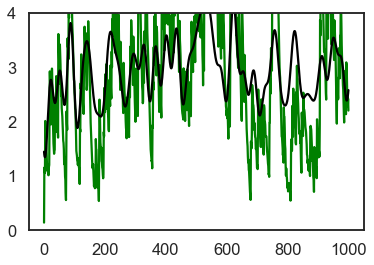

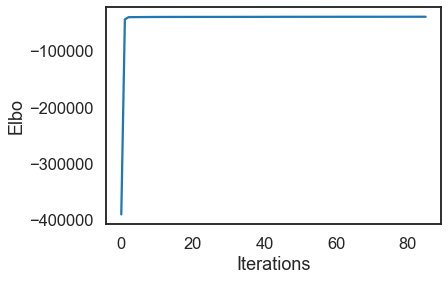

In [62]:
row= 2
column = 3

#neuron 1
recon_traces = softplus(loadings_hat@recon_latent)
recon_traces = loadings_hat@recon_latent
plt.plot(y.T[0],'g')
plt.plot(recon_traces[0].T,'k')
plt.ylim([0,4])

# for i in onp.arange(column):

#   plt.subplot(row,column,i+1)
#   plt.plot(recon_traces[i].T,'k')
#   plt.ylim([0,42])
#   plt.plot(lambdas.T[i]/bin_size,'g')
#   plt.subplot(row,column,i+column+1)
#   plt.plot(samp_data[i].T)
#   plt.ylim([-0.5,15])
#   #hist = sum(y_test_for_honeurs[:,neur,:])/(D-n_hos)

# plt.subplot(row,column,0+1) 
# plt.ylabel('firing rate')
# plt.legend(['Estimated Rate', 'True rate'])  

# plt.subplot(row,column,column+1) 
# plt.ylabel('CA activity')

# a1 = onp.linalg.lstsq(recon_latent.T, latents.T)[0]
# recon_lat_rot = recon_latent.T@a1


# plt.figure(2)
# plt.plot(recon_lat_rot,'k') 
# plt.plot(latents.T,'g')


# #
# plt.subplot(3,1,1)
# plt.ylabel('True rate')
# plt.plot(onp.arange(0,timepoints),rate[0])
# plt.plot(onp.arange(0,timepoints),recon_traces[0], 'k')
# plt.subplot(3,1,2)
# plt.plot(onp.arange(0,timepoints),spks[0])
# plt.ylabel('Spikes')
# plt.subplot(3,1,3)
# plt.plot(onp.arange(0,timepoints),samp_data[0])
# plt.ylabel('Ca activity')
# plt.xlabel('Time (sec)')


plt.figure(3)
plt.plot(-onp.array(elbos))
plt.ylabel('Elbo')
plt.xlabel('Iterations')